# LSTM-архитектура нейронной сети для прогназирование временного ряда

**Disclamer:**
 Результаты полученные при использовании данного метода не говорят о том, хороший это метод или нет. Они лишь дают информацию о том, насколько данный метод подходит для выбранных входных данных.

In [290]:
import pandas as pd
import numpy as np

# для разбиения на тестовую и тренировочную выборки
from sklearn.model_selection import train_test_split

# библиотеку для графиков
import matplotlib.pyplot as plt

# метрики моделей регрессии
from sklearn.metrics import mean_squared_error , mean_absolute_error # mse , mae

# модель линейной регрессии
from sklearn.linear_model import LinearRegression

# градиентный бустинг с кросс-валидацией в библиотеке catboost
from catboost import CatBoostRegressor, Pool, cv

# расширенный тест Дики-Фуллера для проверки на единичные корни
from statsmodels.tsa.stattools import adfuller

# КПСС критерий для проверки на стационарность
from statsmodels.tsa.stattools import kpss

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

from sklearn import metrics

# для выгрузки моделей
import joblib

from pylab import rcParams
import statsmodels.api as sm




import tensorflow
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Activation, LeakyReLU, LSTM, Dropout, Bidirectional, Conv1D, Input, MaxPooling1D, AveragePooling1D
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.optimizers import Adam

from numpy import zeros, newaxis, array

Выгрузим и обработаем данные.
Наши данные представляют из себя количество операций продажи по определенному сценарию.  

In [102]:
sales = pd.read_csv('data_3.csv', index_col=[0])
display(sales.head(5))
sales.info()

,магазин,день,кол-во
0,магазин 3,2019-01-02,1
1,магазин 2,2019-01-02,3
2,магазин 1,2019-01-02,48
3,магазин 3,2019-01-03,3
4,магазин 1,2019-01-03,87


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2606 entries, 0 to 2605
Data columns (total 3 columns):
магазин    2606 non-null object
день       2606 non-null object
кол-во     2606 non-null int64
dtypes: int64(1), object(2)
memory usage: 81.4+ KB


Выгрузили и посмотрели типы. Сразу приведем столбец день к дате. И проверим, все ли даты у нас есть в наличие.

In [103]:
sales['день'] = pd.to_datetime(sales['день'], format='%Y-%m-%d')

display(sales.pivot_table(index='день', values='кол-во', columns = 'магазин'))

print(sales.pivot_table(index='день', values='кол-во', columns = 'магазин').isna().sum())

магазин,магазин 1,магазин 2,магазин 3
день,,,
2019-01-02,48.0,3.0,1.0
2019-01-03,87.0,NaN,3.0
2019-01-04,68.0,1.0,4.0
2019-01-05,75.0,9.0,6.0
2019-01-06,70.0,1.0,5.0
...,...,...,...
2021-05-27,77.0,20.0,5.0
2021-05-28,67.0,26.0,10.0
2021-05-29,70.0,18.0,12.0


магазин
магазин 1     0
магазин 2    17
магазин 3    14
dtype: int64


Отлично. мы знаем, что не для всех магазинов у нас есть данные по каждому месяцу. Исправим это недоразумение. Отсутствие данных = отсутствию продаж, поэтому будем менять на ноль. 

In [104]:
sales = sales.pivot_table(index='день', values='кол-во', columns = 'магазин', fill_value=0)

Кроме того, мы точно знаем, что, например 1 января 2020 года ни один магазин не работал, поэтому дата "2020-01-01" будет отсутствовать, а это плохо. Поэтому ресемплируем данные по дням и заполним пропуски тоже нулями

In [105]:
sales = sales.resample('D').asfreq().fillna(0)

display(sales)
print(sales.isna().sum())

магазин,магазин 1,магазин 2,магазин 3
день,,,
2019-01-02,48.0,3.0,1.0
2019-01-03,87.0,0.0,3.0
2019-01-04,68.0,1.0,4.0
2019-01-05,75.0,9.0,6.0
2019-01-06,70.0,1.0,5.0
...,...,...,...
2021-05-27,77.0,20.0,5.0
2021-05-28,67.0,26.0,10.0
2021-05-29,70.0,18.0,12.0


магазин
магазин 1    0
магазин 2    0
магазин 3    0
dtype: int64


Отлично. Теперь наш времянной ряд приведен в нормальное состояние. И бонусом мы узнали, что не только "2020-01-01" магазины были закрыты, но и еще в какой-то день (размер таблицы вырос с 879 строк до 881 строки). Отсутствовали продажи 1 января 2021г и изначально мы специально умолчали об этом, чтобы проверить правильно ли все отработает.

Посмотрим на графики количества продаж для каждого магазина

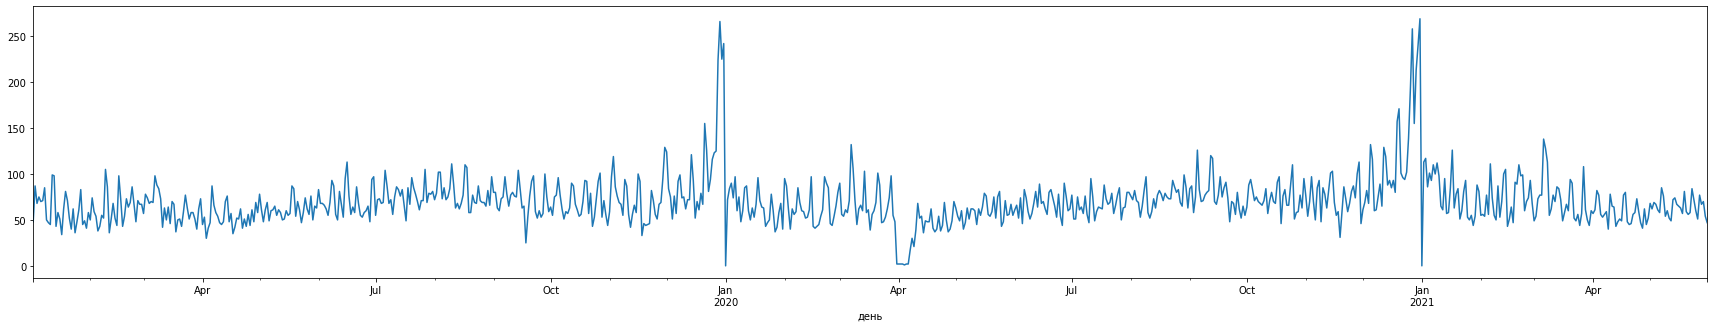

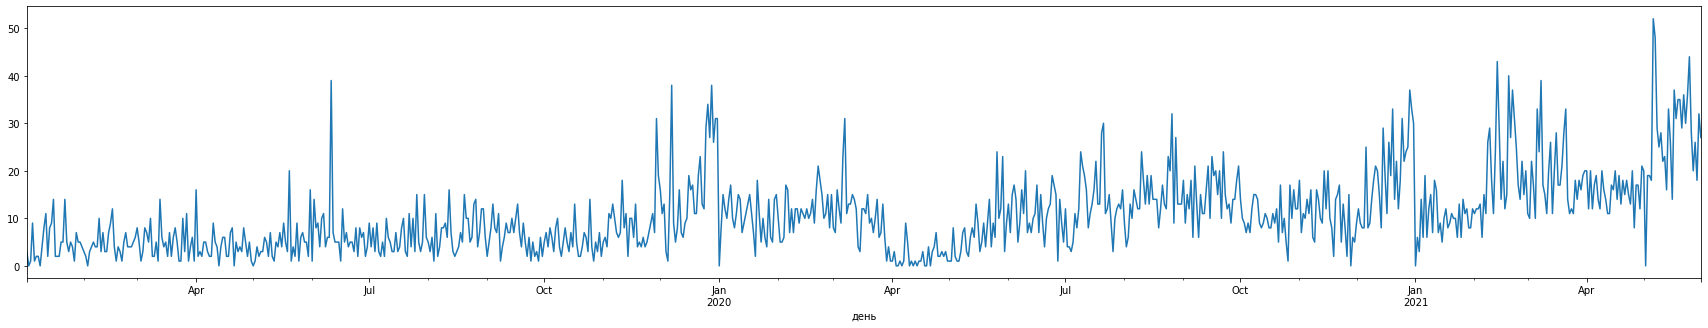

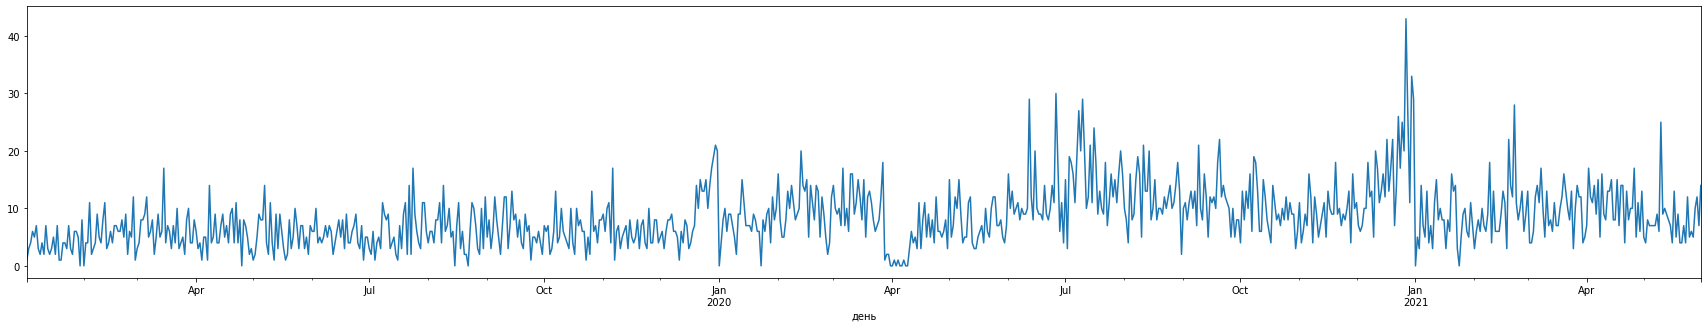

In [106]:
for col in sales.columns:
    sales[col].plot(figsize = (30,5))
    plt.show()

# LSTM для 1 магазина.

Возьмем данные по 1 магазину и попробуем спрогнозировать количество продаж на будущий месяц. 

Для примера возьмем "магазин 2", потому он выглядит как менее стационарный относительно "магазина 1" и, в отличие от "магазина 3" в конце периода данных явно имеет изменение объемов продаж.


In [260]:
one = sales['магазин 2']

Декомпозируем ряд на тренд сезонность и шумы и посмотрим на результат.

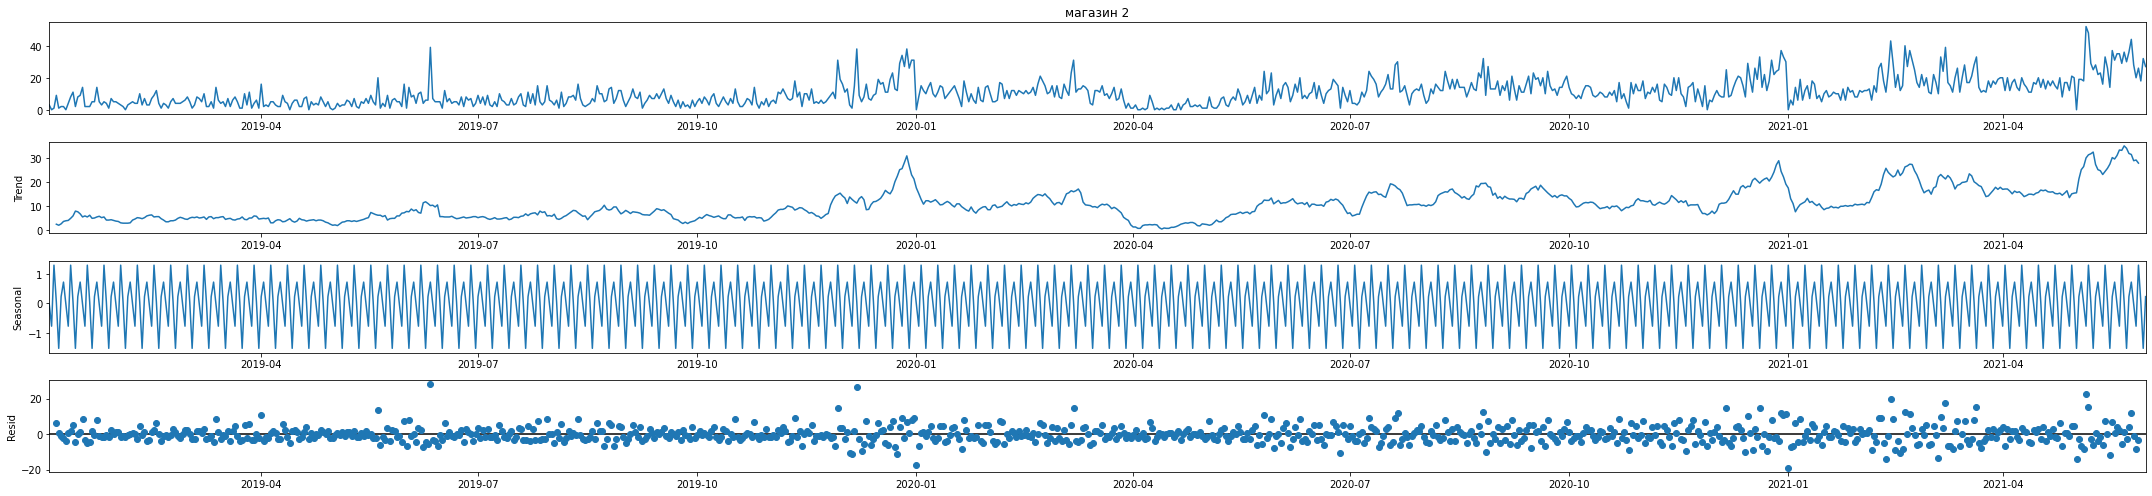

In [291]:

rcParams['figure.figsize'] = (30, 7)

decomposition = sm.tsa.seasonal_decompose(one, model='additive')

fig = decomposition.plot()
plt.show()


Отлично. В наших данных есть внутригодовая и внутринедельная сезонность, долгосрочный восходящий тренд и увеличение дисперсии шумов со временем. Полный набор...
Чтож, будем разбираться.

Мы знаем, что последний доступный месяц наблюдений - май 2021 года, в полном объеме. Его и возьмем в качестве данных на которых будем валидировать модель. Остальные данные используем для обучения.

In [261]:
one_valid = one[-31:]
one_train = one[:-31]

Мы знаем, что чем более стационарны входные данные - тем более адекватный результат дают нейронки. Проверим наш тренировочный ряд на стационарность расширенным критерием Дики-Фуллера. Этот критерий проверяет гипотезу о наличии единичного коря в авторегрессионной модели порядка n и, если такой корень находится, то процесс считается не стационарным.

In [262]:
#проверка на стационарность

def adf_test(data, border, print_info):

    result = adfuller(data.values)
    adf_stat = result[0]
    p_value = result[1]
    n_lags = result[2]
    critical_val_1 = result[4]['1%']
    critical_val_5 = result[4]['5%']
    critical_val_10 = result[4]['10%']

    
    if (p_value < border) and (adf_stat < critical_val_5): 
        conclusion ='stationary'
        return_value = True
    else: 
        conclusion ='non-stationary. p-value: {:.2f}; critical value on 5%: {:.2f}'.format(p_value, critical_val_5 )
        return_value = False

    if print_info:
        print('ADF Statistic: {:.2f}'.format(adf_stat))
        print ('5% critical value:{:.2f}'.format(critical_val_5))
        print('p-value: {:.2f}'.format(p_value))
        print ('p-value border:{:.2f}'.format(border))
        print('num lags:', n_lags)      
        print(f'Conclusion: {conclusion}')

    return return_value
    
    


critical_val = 0.05

adf_test(one_train, critical_val, print_info=True)

ADF Statistic: -3.22
5% critical value:-2.87
p-value: 0.02
p-value border:0.05
num lags: 15
Conclusion: stationary


True

Расширенный критерий Дики-Фуллера говорит, что наш ряд стационарен. Но мы не знаем, он стационер по данным или он стационарен только по тренду. 

Узнаем это. Для этого используем другой критерий - КПСС, который в нулевой гипотезе предполагает стационарность вокруг среднего или линейного тренда, а в случае отвержения означает, что присутствует единичный корень. 

Вообще, в сочетании расширенного теста Дики-Фуллера и КПСС возможны 4 варианта:
1) Не отвергаем нулевую гипотезу + отвергаем нулевую гипотезу  - в этом случае имеется единичный корень и ряд не стационарен
2) Отвергаем нулевую гипотезу + не отвергаем нулевую гипотезу - в этом случае ряд не имеет единичного корня и стационарен
3) Не отвергаем нулевую гипотезу + не отвергаем нулевую гипотезу - ряд не достаточной длинны
4) Отвергаем нулевую гипотезу + отвергаем нулевую гипотезу - в ряду важную роль играет непостояносто дисперсии и случайной ошибки (гетероскедастичность) и структурные разрывы (например выбросы продаж в декабре) будут иметь большое влияние на выводы.

In [263]:

def kpss_test(data, border, print_info):    
    result= kpss(data)
   
    
    kpss_stat = result[0]
    p_value = result[1]
    n_lags = result[2]

    critical_val_1 = result[3]['1%']
    critical_val_5 = result[3]['5%']
    critical_val_10 = result[3]['10%']

    

    if p_value < border:
        conclusion ='non-stationary'
        return_value = False
    else:
        conclusion ='stationary'
        return_value = True


    if print_info:
        print('KPSS Statistic: {:.2f}'.format(kpss_stat))
        print('5% critical value:{:.2f}'.format(critical_val_5))
        print('p-value: {:.2f}'.format(p_value))
        print ('p-value border:{:.2f}'.format(border))
        print('num lags:', n_lags)

        print(f'Conclusion: {conclusion}')

    return return_value




kpss_test(one_train, critical_val, print_info=True)

KPSS Statistic: 2.25
5% critical value:0.46
p-value: 0.01
p-value border:0.05
num lags: 21
Conclusion: non-stationary


C:\Users\Baturin.GG\Anaconda3\envs\keras_env_2\lib\site-packages\statsmodels\tsa\stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
C:\Users\Baturin.GG\Anaconda3\envs\keras_env_2\lib\site-packages\statsmodels\tsa\stattools.py:1907: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning


False

Отлично, на наш ряд большое влияние оказывает гетероскедастичность в данных. Избавимся от нее взятием разностей. Поскольку мы не знаем, сколько разностей надо взять, то будем делать это в цикле, считать разности в счетчике, а ряд складывать в переменную


In [264]:
# опеределим, разности какого порядка надо взять, чтоб привести ряд к стационарному
n_differencing=0
stationary = one_train

for i in range(10):
    if adf_test(stationary, critical_val, print_info=False) and kpss_test(stationary, critical_val, print_info=False):
        break
    else:
        n_differencing += 1
        stationary = one_train.diff().dropna()
    





C:\Users\Baturin.GG\Anaconda3\envs\keras_env_2\lib\site-packages\statsmodels\tsa\stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
C:\Users\Baturin.GG\Anaconda3\envs\keras_env_2\lib\site-packages\statsmodels\tsa\stattools.py:1907: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning
C:\Users\Baturin.GG\Anaconda3\envs\keras_env_2\lib\site-packages\statsmodels\tsa\stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Curr

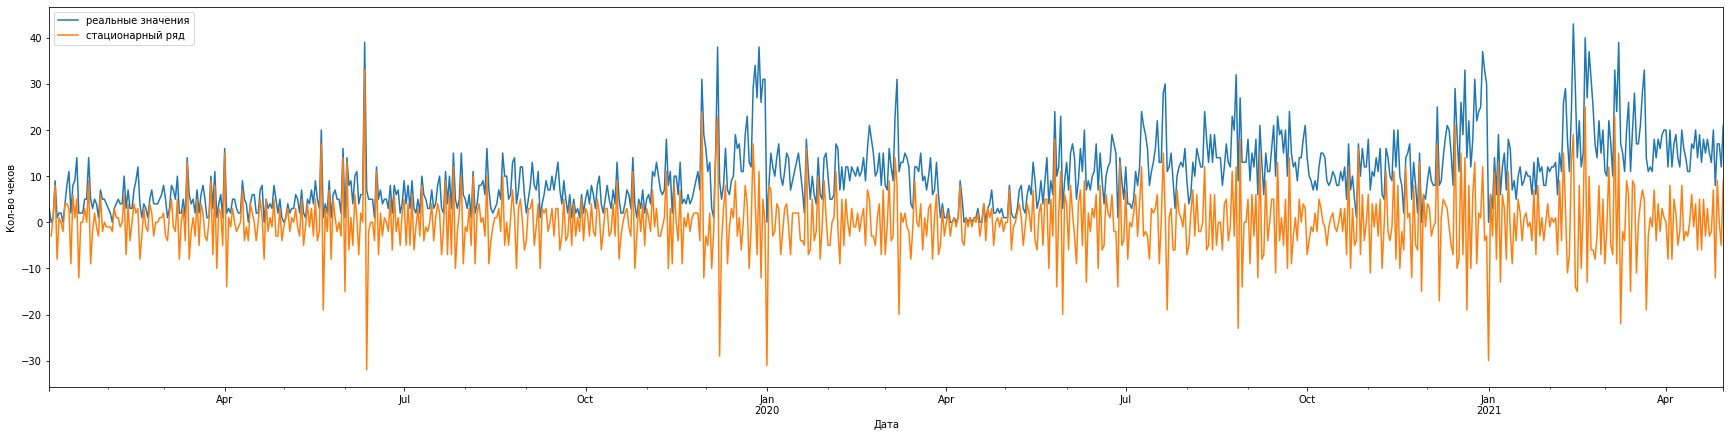

порядок разностей: 1


In [265]:

ax = one_train.plot(figsize=(30,7), label='реальные значения')
stationary.plot(ax=ax, label = 'стационарный ряд')

ax.set_xlabel('Дата')
ax.set_ylabel('Кол-во чеков')
plt.legend()
plt.show()

print(f'порядок разностей: {n_differencing}')

Теперь стандиртизируем стационарный ряд

In [266]:
scaler = MinMaxScaler()

scaler.fit(
    # поскольку стационарный ряд это Series, a методу нужен DataFrame - преобразуем
    stationary.to_frame()
    )
scaler_stationary = pd.DataFrame(scaler.transform(
                                                    # поскольку стационарный ряд это Series, a методу нужен DataFrame - преобразуем
                                                    stationary.to_frame()
                                                    ),  
                                                    columns=one_train.to_frame().columns
                                                )



# поскольку стационарный ряд короче исходного на порядок разностей, то нужно сдвинуть
# исходный ряд на порядок разностей, чтобы правильно проставить индексы
scaler_stationary.index = one_train.iloc[n_differencing:].index

# проверим, остался ли ряд стационарен. Если да, то напечатает 2 раза True
print(adf_test(scaler_stationary, critical_val, print_info=False))
print(kpss_test(scaler_stationary, critical_val, print_info=False))

# преобразуем стационарный стандартезированный ряд из DataFrame в Series
scaler_stationary = scaler_stationary.squeeze(axis=1)

True
True


C:\Users\Baturin.GG\Anaconda3\envs\keras_env_2\lib\site-packages\statsmodels\tsa\stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
C:\Users\Baturin.GG\Anaconda3\envs\keras_env_2\lib\site-packages\statsmodels\tsa\stattools.py:1911: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning


Поскольку у нас 1 ряд данных, нам нужно разбить его на вектора на которых будем учить нейронку. На входе будем подавать последовательность определенной длинны и на выходе будем ожидать прогноз на то количество деней вперед, сколько у нас дней в валидационной выборке

In [278]:
dataset = scaler_stationary.values # для стандартизированных данных

# определим на сколько шагов вперед будем смотреть (длинну выходного вектора)
n_steps = one_valid.shape[0] 

# определим, сколько дней до даты начала прогноза будем использовать (длинна входного вектора)
n_steps_past = 91


# разобъем многомерный временной ряд на признаки (предыдущие значения) и целевые переменные (то что надо спрогнозировать)
def split_sequences(sequences, n_steps_future,  n_steps_past):
	X, y = list(), list()
	for i in range(len(sequences)):
		# ищем конец признаков
		end_ix = i + n_steps_past
		end_iy = end_ix + n_steps_future
		# проверяем, не находимся ли мы в конце выборки
		if end_ix > len(sequences)-1:
			break
		if end_iy > len(sequences)-1:
			break
		# собираем признаки и целевые переменные
		seq_x, seq_y = sequences[i:end_ix], sequences[end_ix:end_iy]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)


X, y = split_sequences(dataset, n_steps, n_steps_past)

In [279]:
print(X.shape)
print(y.shape)

(727, 91)
(727, 31)


Теперь нужно подготовить данные к формату в котором их хочет видеть LSTM. 

Мы будем тренироваться прогнозировать даты 92 по 123ую, на основе предыдущих 91 даты. Каждый раз будем сдвигаться на 1 дату дальше. Таким образом, на втором шаге мы будем прогнозировать c 93 по 124ую дату на основе данных со 2 по 92ую.
Саму сеть мы будем описывать с использованием functional API библиотеки Keras.

In [280]:
tensorflow.keras.backend.clear_session()


n_features = 1

def create_model(n_steps_past):

    input = Input(shape=(n_steps_past, 1))
    
    # количество фильтров обычно задается как 2/3 от количества вектора, который входит в слой
    num_of_filters = int(np.round((n_steps_past*(2/3)),0))

    x = Conv1D(filters=num_of_filters, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1])(input)

    # pool_size обычно считается по форуле (размерность входного вектора-количество фильтров)+1
    x = MaxPooling1D(pool_size=(n_steps_past-num_of_filters)+1)(x)

    x = Bidirectional(LSTM(64, recurrent_dropout=0.2, return_sequences=True))(x)
    x = Bidirectional(LSTM(64))(x)
    x = Dropout(0.1)(x)
    y = Dense(n_steps)(x)

    model = Model(inputs=input, outputs=y)




    return model

model = create_model(n_steps_past)

После этих шагов шейпы будут X.shape = (728, 90); y.shape = (728, 31), а наши входные данные подразумевают шейп X.shape = (728, 90, 1) поэтому - исправим этот недостаток

In [281]:
X_1 = X[:,:,newaxis]

Теперь можно обучить нейронку. Но чтобы ее обучить правильно, нам хотелось бы знать, на каком уровне learning_rate наша функция потерь минимальна. Таким образом мы затратим меньше времени на обучение без потери точности. Определим этот уровень взглянув на график зависимости потер от learning_rate. Изучая нижнюю часть графика, где он стабилен - найдем оптимальный learning_rate

In [282]:
opt = Adam(lr=1e-8, clipvalue=1.0)
model.compile(optimizer=opt,   loss = 'mae')

print(model.summary())



# model.fit(X_1, y, epochs=100)

lr_schedule = tensorflow.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-10 * 10**(epoch / 10)) # будем менять learning_rate после каждой эпохи в диапазоне от 1е-8 в первой, до 1е-3 в сотой

history = model.fit(X_1, y, epochs=100, callbacks=[lr_schedule], validation_split=0.2, shuffle=False)



Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 91, 1)]           0         
_________________________________________________________________
conv1d (Conv1D)              (None, 91, 61)            366       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 2, 61)             0         
_________________________________________________________________
bidirectional (Bidirectional (None, 2, 128)            64512     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 128)               98816     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 31)                3999  

(1e-10, 1.0, 0.0, 0.2)

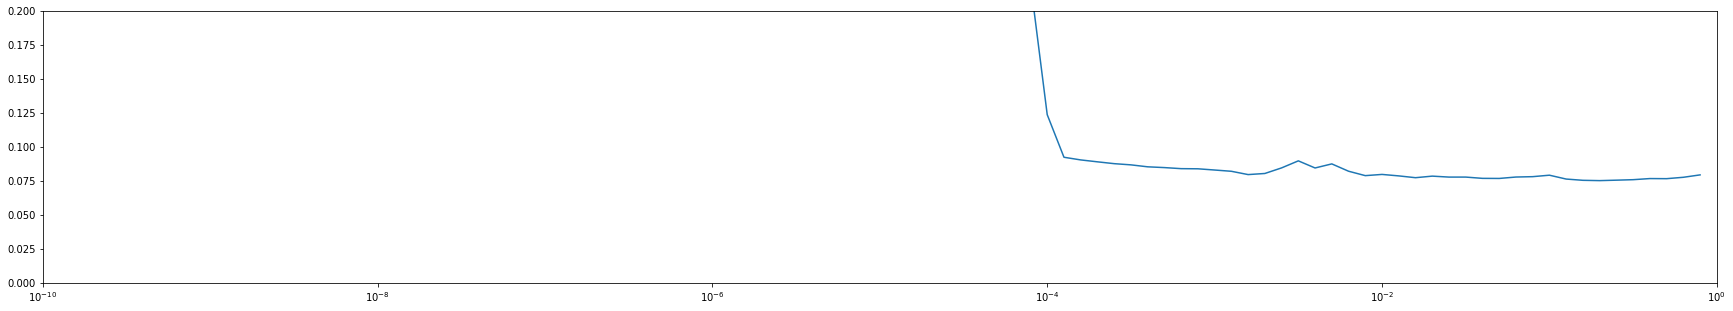

In [283]:
# построим график зависимости функции потерь от learning_rate
# затем изучим нижнюю часть графика и там, где график стабильный
# и будет оптимальный learning_rate
plt.figure(figsize=(30,5))
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-10, 1, 0, 0.2])

Попробуем обучиться на learning_rate 1e-1

In [284]:
tensorflow.keras.backend.clear_session()


model = create_model(n_steps_past)
opt = Adam(lr=5e-3, clipvalue=1.0)
model.compile(optimizer=opt,   loss = 'mae')
model.fit(X_1, y, epochs=4000, validation_split=0.2, shuffle=False, callbacks = [EarlyStopping(monitor='loss', patience=70)])


Train on 581 samples, validate on 146 samples
Epoch 1/4000
581/581 [==============================] - 2s 4ms/sample - loss: 0.2017 - val_loss: 0.1103
Epoch 2/4000
581/581 [==============================] - 0s 451us/sample - loss: 0.0931 - val_loss: 0.1118
Epoch 3/4000
581/581 [==============================] - 0s 445us/sample - loss: 0.0830 - val_loss: 0.1091
Epoch 4/4000
581/581 [==============================] - 0s 445us/sample - loss: 0.0806 - val_loss: 0.1076
Epoch 5/4000
581/581 [==============================] - 0s 451us/sample - loss: 0.0796 - val_loss: 0.1078
Epoch 6/4000
581/581 [==============================] - 0s 445us/sample - loss: 0.0786 - val_loss: 0.1075
Epoch 7/4000
581/581 [==============================] - 0s 441us/sample - loss: 0.0784 - val_loss: 0.1077
Epoch 8/4000
581/581 [==============================] - 0s 450us/sample - loss: 0.0779 - val_loss: 0.1075
Epoch 9/4000
581/581 [==============================] - 0s 453us/sample - loss: 0.0772 - val_loss: 0.1079
Ep

Отлично, нейронку обучили. Теперь можно переходить к этапу прогнозирования.

Для начала подготовим данные для прогноза. Мы прогнозируем май 2021 года (31 день), и наш порядок разностей лежит в переменной n_differencing. С учетом того, что мы будем приводить ряд к стационарному - нам нужно последние n_steps_past дней из тренировочной выборки. Затем на этих входных данных спрогнозируем май 2021 и потом сделаем обратную стандартизацию прогноза и переведем из стационарного процесса в исходный.

In [285]:
# подготовим входные данные для прогноза
scaler_stationary_valid = scaler_stationary[-(n_steps_past):]
scaler_stationary_valid.shape

(91,)

Теперь приведем шейп к тому виду, который ожидает от нас нейронка, а затем сделаем прогноз и сразу сделаем действие обратное стандартизации

In [286]:
# приведем наши данные в тот шейп, который ожидает от нас модель
X_2 = scaler_stationary_valid.values.reshape(1,-1,1)

# сделаем обратную стандартизацию и перейдем просто к стационарному ряду
stationary_valid = scaler.inverse_transform(model.predict(X_2, verbose=0)) 


Вспомним, что когда мы приводили ряд к стационарному - мы проверяли, если ряд стационарен с самого начала, то мы никак его не преобразовывали, а значит, и выходные данные после де-стандартизации нам не нужно де-стационизировать. Признаком того, что мы приводили ряд к стационарному может служить отличное от нуля значение порядка разности, который мы брали, чтобы привести ряд к стационарному.

In [287]:
if(n_differencing !=0):
    # прогноз стационарного не стандартизированного ряда
    test = stationary_valid

    # последний известный день (если n_differencing = 1)/ предпоследний (если n_differencing = 2) и тд.
    last_observ = one[-(one_valid.shape[0]+n_differencing)]

    # перейдем от стационарного ряда полученными порядком разности n_difference к обычному
    i=0
    forecast = []
    for el in test[0]:
        
        if i == 0:
            value = el+last_observ
            forecast.append(value)
        else:
            value = el+forecast[i]
            i+=1


    results = pd.DataFrame(np.round(forecast,0), index=one_valid.index, columns=['прогноз'])
else:
    results = pd.DataFrame(np.round(stationary_valid,0).T, index=one_valid.index, columns=['прогноз'])

Теперь можно и метрики посчитать и графики нарисовать

mae:9.129032258064516
rmse:12.447308298221255
реальное число продаж за месяц: 856.0
прогнозное число продаж за месяц: прогноз    657.0
dtype: float64
точность прогноза по дням: 59.43046410952966


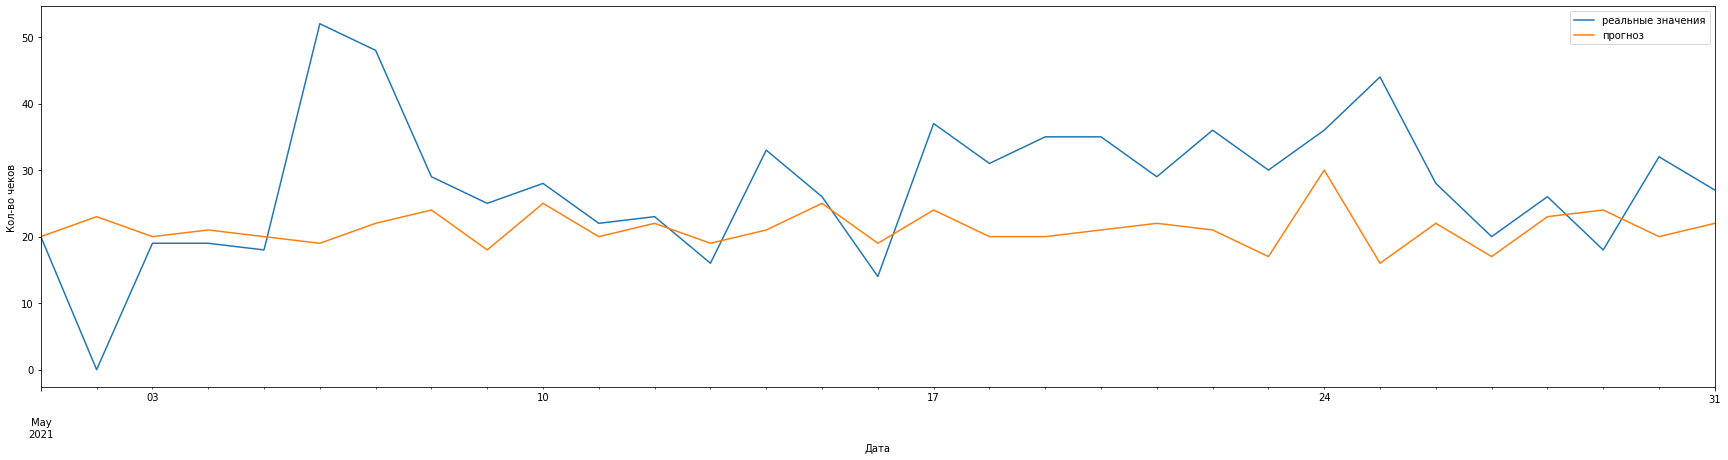

In [288]:
mae = mean_absolute_error(one_valid, results)
rmse = mean_squared_error(one_valid, results)**0.5
true_month = one_valid.sum()
pred_month =  results.sum()

print(f'mae:{mae}')
print(f'rmse:{rmse}')
print(f'реальное число продаж за месяц: {true_month}')
print(f'прогнозное число продаж за месяц: {round(pred_month,0)}')



def mse_for_point(row):
    error = row['error']
    pred = row[results.columns]
    return (error**2)/(pred**2)



ratio = one_valid.to_frame().join(results)
ratio['error'] = ratio[ratio.columns[0]]-ratio[ratio.columns[1]]
ratio['mse'] = ratio.apply(mse_for_point, axis=1)
print(f'точность прогноза по дням: {(1 - ratio.mse.mean())*100}')


# нарисуем график
ax = one_valid.plot(figsize=(30,7), label='реальные значения')
results.plot(ax=ax, label = 'прогнозные значения')

ax.set_xlabel('Дата')
ax.set_ylabel('Кол-во чеков')
plt.legend()
plt.show()


# Вывод
При оценке результатов следует учитывать, что мы выбрали самый "неудобный" ряд, в котором не только гетероскедастичность играет большое значение, но и тренд изменяется ровно в том периоде, который мы прогнозируем. 

С учетом это факта и того, что SARIMA на этом датасете дала нам точность на закрытой выборке всего в 12% - точность прогноза в 59% выглядит солидно. 

В целом, прогноз можно и улучшить, путем добавления признаков, например:
- выходные дни
- федеральные и региональные праздничные дни
- предпразничные дни
- календарь маркетинговых активностей 

Но это уже другая история. В рамках этого ноутбука была задача построить максимально точную авторегрессионную модель с использование LSTM архетиктуры нейронной сети.

